In [1]:
from matplotlib import pyplot as plt
import numpy as np
import gzip
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import utils
import urllib.request

%matplotlib inline

In [2]:
files = [
  't10k-images-idx3-ubyte.gz',
  't10k-labels-idx1-ubyte.gz',
  'train-images-idx3-ubyte.gz',
  'train-labels-idx1-ubyte.gz'
]
for file in files: urllib.request.urlretrieve('https://github.com/davidflanagan/notMNIST-to-MNIST/blob/master/'+file+'?raw=true', '/content/'+file)

In [3]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

In [4]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

X_train = train_data.reshape(-1, 28,28, 1)  # add grey channel
X_test = test_data.reshape(-1, 28,28, 1)

n_classes = 10
Y_train = utils.to_categorical(train_labels, n_classes) # 1-hot
Y_test = utils.to_categorical(test_labels, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [5]:
# Shape of training set
print("Training set (images) shape: {shape}".format(shape=X_train.shape))
# Shape of test set
print("Test set (images) shape: {shape}".format(shape=X_test.shape))
# Type of data - should be float32
print('data type: ', X_train.dtype, X_test.dtype)

Training set (images) shape: (60000, 28, 28, 1)
Test set (images) shape: (10000, 28, 28, 1)
data type:  float32 float32


Text(0.5, 1.0, '(Label: D)')

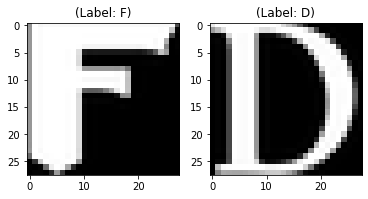

In [6]:
# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [7]:
# rescale the data in range 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

## Create a shallow MLP encoder

In [72]:
# STARTING FROM HERE, COMPLETE THE CODE WHERE YOU SEE ...
# size of our encoded representation
encoding_dim = 32  # this is the number of neurons you chose to encode

# define input layer, encoded layer and decoded layer
input_img = Input((784))
dense_down = Dense(100, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(dense_down)
dense_up = Dense(100, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(dense_up)

# define autoencoder model 
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input((encoding_dim))

# retrieve the last layer of the autoencoder model
decoder_dense_up = autoencoder.layers[-2](encoded_input)
decoder_decoded = autoencoder.layers[-1](decoder_dense_up)

# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_decoded)

print(autoencoder.summary())
print(encoder.summary())
print(decoder.summary())

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_52 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_53 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_54 (Dense)             (None, 100)               3300      
_________________________________________________________________
dense_55 (Dense)             (None, 784)               79184     
Total params: 164,216
Trainable params: 164,216
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_35"
_________________________________________________________________
Layer (type)                 

In [73]:
# compile the network - use adam optimizer, beware to use the good loss function
autoencoder.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [74]:
# for visualisation
def plot_result(x_test,decoded_imgs):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [75]:
X_train_flat = X_train.reshape(60000,784)
X_test_flat = X_test.reshape(10000,784)

In [76]:
# train the network
EPOCHS = 1000
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

log = autoencoder.fit(
    X_train_flat, X_train_flat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test_flat, X_test_flat),
    callbacks=[early_stopping]
)

Epoch 1/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0781 - val_loss: 0.0311
Epoch 2/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0341 - val_loss: 0.0271
Epoch 3/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0314 - val_loss: 0.0260
Epoch 4/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0304 - val_loss: 0.0252
Epoch 5/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0296 - val_loss: 0.0242
Epoch 6/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0288 - val_loss: 0.0236
Epoch 7/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0275 - val_loss: 0.0225
Epoch 8/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0270 - val_loss: 0.0223
Epoch 9/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0264 - val_loss: 0.0222
Epoch 10/1000
1875/1875 [==============================] - 4s 2m

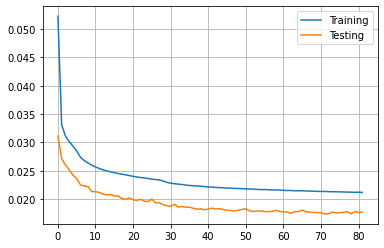

In [77]:
plt.plot(log.history['loss'], label='Training')
plt.plot(log.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

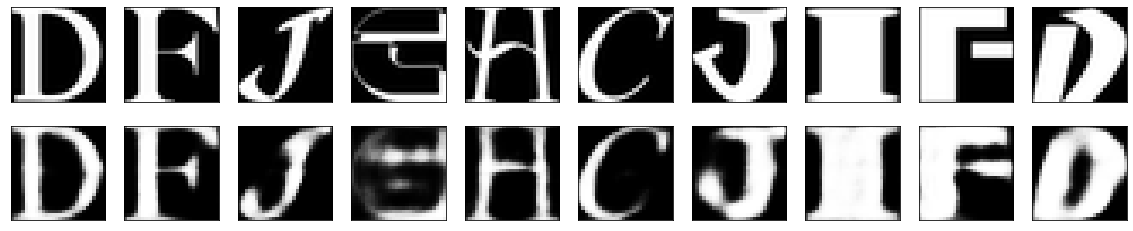

In [78]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test_flat)
decoded_imgs = decoder.predict(encoded_imgs)
plot_result(X_test_flat,decoded_imgs)

### Use the encoded features to train another classifier

In [79]:
X_train_feat = encoder.predict(X_train_flat)
X_test_feat = encoder.predict(X_test_flat)

# Normalization (standardization) of training and test sets
scaler = StandardScaler()  
scaler.fit(X_train_feat)
X_train_feat = scaler.transform(X_train_feat)  
X_test_feat = scaler.transform(X_test_feat)

print(X_train_feat.shape)
print(Y_train.shape)
print(X_test_feat.shape)
print(Y_test.shape)

(60000, 32)
(60000, 10)
(10000, 32)
(10000, 10)


In [80]:
# using the features to train a SVM
clf = SVC(kernel='linear', cache_size=7000)
clf.fit(X_train_feat, train_labels)

SVC(C=1.0, break_ties=False, cache_size=7000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [81]:
y_pred = clf.predict(X_test_feat)

# Print classification results with confusion matrix
print("Classification report for classifier %s:\n%s\n" %
      (clf, metrics.classification_report(test_labels, y_pred)))
# print("\nConfusion matrix:\n%s" % metrics.confusion_matrix(test_labels, y_pred))

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=7000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1000
           1       0.88      0.88      0.88      1000
           2       0.91      0.91      0.91      1000
           3       0.93      0.90      0.92      1000
           4       0.88      0.85      0.86      1000
           5       0.89      0.93      0.91      1000
           6       0.88      0.89      0.88      1000
           7       0.89      0.89      0.89      1000
           8       0.86      0.85      0.86      1000
           9       0.88      0.92      0.90      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weig

## Create a conv autoencoder

In [105]:
input_img = Input((28,28,1))
# encoder
conv1 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D()(conv1) #14 x 14 x 32
conv2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D()(conv2) #7 x 7 x 64
conv3 = Conv2D(128, kernel_size=3, padding='same', activation='relu')(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = Conv2D(128, kernel_size=3, padding='same', activation='relu')(conv3) #7 x 7 x 128
up1 = UpSampling2D()(conv4) # 14 x 14 x 128 (UpSampling2D())
conv5 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(up1) # 14 x 14 x 64
up2 = UpSampling2D()(conv5) # 28 x 28 x 64
decoded = Conv2D(1, kernel_size=1, padding='same', activation='relu')(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam()
)
autoencoder.summary()

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 7, 7, 128)         147

In [106]:
EPOCHS = 10
BATCH_SIZE = 128

log = autoencoder.fit(
    X_train, X_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test, X_test)
)

Epoch 1/10
469/469 [==============================] - 232s 493ms/step - loss: 0.0538 - val_loss: 0.0252
Epoch 2/10
469/469 [==============================] - 232s 494ms/step - loss: 0.0262 - val_loss: 0.0249
Epoch 3/10
469/469 [==============================] - 231s 493ms/step - loss: 0.0255 - val_loss: 0.0246
Epoch 4/10
469/469 [==============================] - 231s 493ms/step - loss: 0.0252 - val_loss: 0.0243
Epoch 5/10
469/469 [==============================] - 231s 493ms/step - loss: 0.0250 - val_loss: 0.0239
Epoch 6/10
469/469 [==============================] - 231s 493ms/step - loss: 0.0249 - val_loss: 0.0244
Epoch 7/10
469/469 [==============================] - 231s 493ms/step - loss: 0.0250 - val_loss: 0.0239
Epoch 8/10
469/469 [==============================] - 231s 493ms/step - loss: 0.0250 - val_loss: 0.0238
Epoch 9/10
469/469 [==============================] - 231s 493ms/step - loss: 0.0248 - val_loss: 0.0239
Epoch 10/10
469/469 [==============================] - 231s 493m

### Predict on test data

In [107]:
decoded_imgs = autoencoder.predict(X_test, verbose=0)
print(decoded_imgs.shape)

(10000, 28, 28, 1)


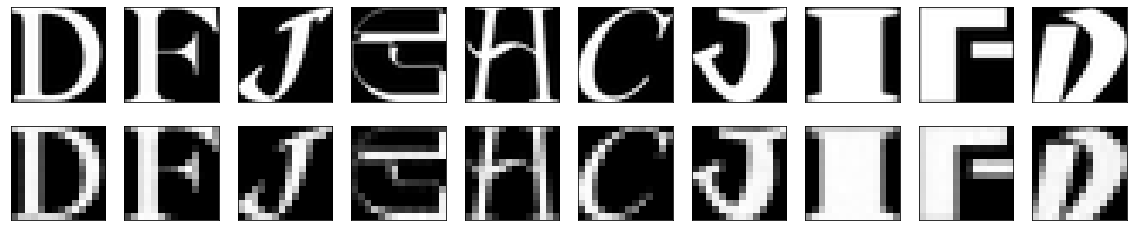

In [108]:
plot_result(X_test_flat,decoded_imgs)

## Denoising autoencoder
First add some noise.

In [119]:
noise_factor = 0.25 #chose a noise factor between 0.0 and 1.0
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

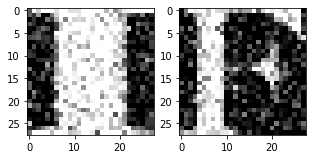

In [120]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [121]:
# REDEFINE HERE A CONV AUTOENCODER FOR THE DENOISING WITH A SIMILAR ARCHITECTURE
input_img = Input((28,28,1))
# encoder
conv1 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D()(conv1) #14 x 14 x 32
conv2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D()(conv2) #7 x 7 x 64
conv3 = Conv2D(128, kernel_size=3, padding='same', activation='relu')(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = Conv2D(128, kernel_size=3, padding='same', activation='relu')(conv3) #7 x 7 x 128
up1 = UpSampling2D()(conv4) # 14 x 14 x 128 (UpSampling2D())
conv5 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(up1) # 14 x 14 x 64
up2 = UpSampling2D()(conv5) # 28 x 28 x 64
decoded = Conv2D(1, kernel_size=1, padding='same', activation='relu')(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam()
)
autoencoder.summary()

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 7, 7, 128)         147

In [122]:
# train on the noisy images and use as target the original clean images
log = autoencoder.fit(X_train_noisy, X_train, batch_size=128, epochs=1,
                        verbose=1, validation_data=(X_test_noisy, X_test))

469/469 [==============================] - 228s 486ms/step - loss: 0.0689 - val_loss: 0.0281


In [123]:
decoded_imgs = autoencoder.predict(X_test_noisy, verbose=0)
print(decoded_imgs.shape)

(10000, 28, 28, 1)


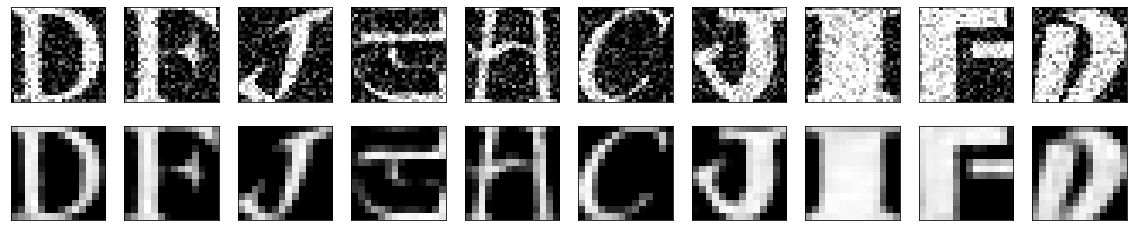

In [124]:
plot_result(X_test_noisy,decoded_imgs)